# <div align="center"> Implementation of GIS-MCDA with the *r.mcda.ahp* module in GRASS GIS</div>

<div align="center"> 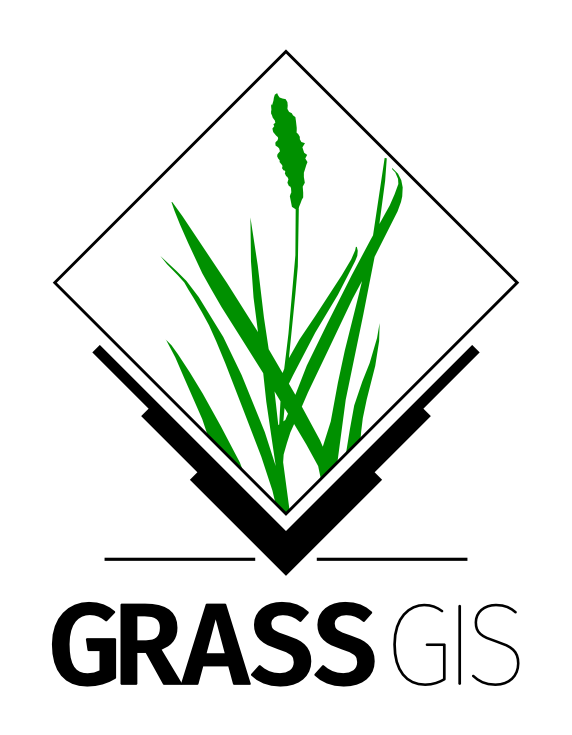 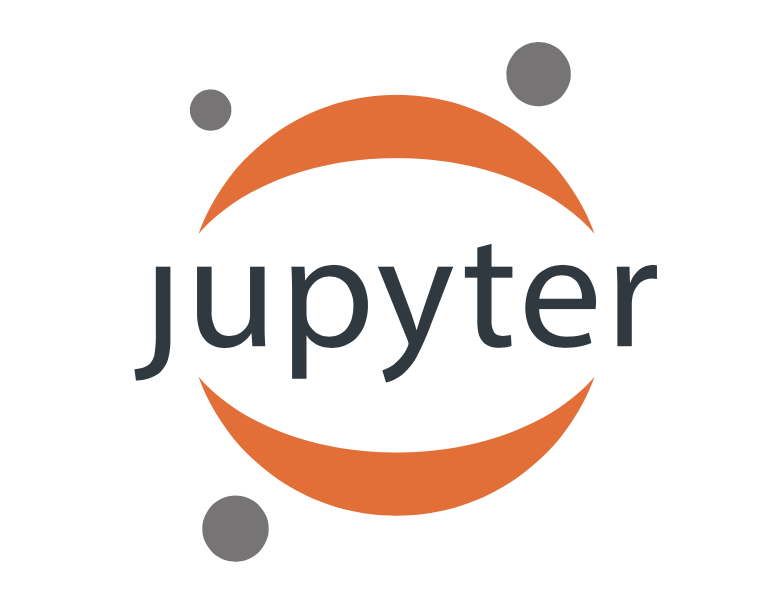</div>


# 0. Sources and data

**Sources**: 
- [neteler/jupyter_sentinel2_grass_gis](https://github.com/neteler/jupyter_sentinel2_grass_gis/blob/main/sentinel2_grass_gis.ipynb)

- [tomasvsm/OBIA_GRASS](https://github.com/tomasvsm/OBIA_GRASS/blob/main/OBIA_classification_PNeo.ipynb)
- [Course GRASS GIS (Vero)](https://veroandreo.github.io/curso-grass-gis/)
- [Workshopp GRASS GIS FOSS4G](https://github.com/ncsu-geoforall-lab/grass-gis-workshop-foss4gna-2023)



**Data**: 
- Study area: [IGN](https://www.ign.gob.ar/NuestrasActividades/InformacionGeoespacial/CapasSIG) ${\to}$ Geodesia y demarcación ${\to}$ Polígono ${\to}$ Gobierno Local (gid: 1385; Cordoba)

- [Sentinel-2](https://dataspace.copernicus.eu/)
- DEM: Modelo Digital de Elevaciones (5m). IDECOR. Descargas ${\to}$ Geografia fisica ${\to}$  [DEM](https://www.mapascordoba.gob.ar/#/descargas) 5m
- [FABDEM](https://gee-community-catalog.org/projects/fabdem/): Forest And Buildings removed Copernicus 30m DEM. 

    (Córdoba: S40W070-S30W060_FABDEM_V1-2.zip ; S32W065_FABDEM_V1-2.tif)
- [Open buildings](https://sites.research.google/open-buildings/): footprints of buildings from high resolution satellite imagery. 

    (Córdoba: 943_buildings.csv.gz . En QGIS lo pasé a gpkg y reproyecté a 5346)

# 1. Activation of GRASS and the working environment

<div> 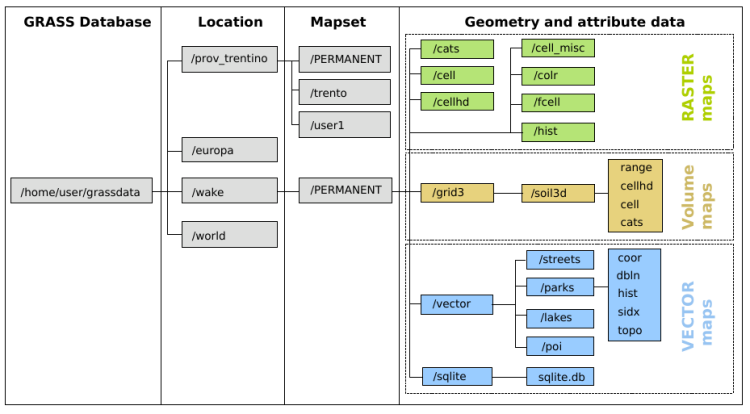</div>

[Diagram of GRASS file structure](https://grass.osgeo.org/programming8/)

In [ ]:
# Check GRASS instalation path
!grass --config path

In [ ]:
# Import Python standard library and IPython packages we need.
import os
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

In [ ]:
# Create a new location/project
#gs.run_command("g.proj",epsg=5346,location="posgar2007_4_cba",flags="c")

In [ ]:
# Create a new mapset
#gs.run_command("g.mapset",mapset="MCDA",flags="c")

In [ ]:
# Definition database, project, mapset
# Set data directory
homedir = "/home/tomas"

# GRASS GIS database variables
gisdata = os.path.join(homedir, "gisdata")
grassdata = os.path.join(homedir, "grassdata")
project = "posgar2007_4_cba"
mapset = "MCDA"

os.chdir(homedir)

In [ ]:
# Start the GRASS GIS Session
session = gj.init(grassdata, project, mapset)

In [ ]:
# check the CRS
print(gs.read_command("g.proj", flags="p"))

# 2.  Create an area of interest from a vector

In [ ]:
# Import
gs.run_command("v.import", input=homedir+"/gisdata/GIS_MCDA/municipios_arg/municipio.shp", output="municipios")

# Extract one value from vector
gs.run_command("v.extract", input="municipios", where="gid = 1385", output="cba")

# Show attributes
gs.vector_db_select('cba')['values']

In [ ]:
# buffer single tile
gs.run_command("v.buffer", input="cba", where="gid = 1385", distance="1000",
               output="tile_cba_1km")

# show metadata
gs.vector_info("tile_cba_1km")

In [ ]:
# display radio_urbano_cba vector
cba_map = gj.InteractiveMap(width = 400, use_region=True, tiles="OpenStreetMap")
cba_map.add_vector("tile_cba_1km")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
## guardar el vector como archivo
"""gs.run_command("v.out.ogr",
               input="tile_cba_1km",
               output="tile_cba_1km.gpkg")"""

In [ ]:
# set as computational region
# set the computational region to the extent of Cordoba urban area
gs.run_command("g.region",
               vector="tile_cba_1km",
               flags="p")

# 3. Sentinel-2 processing

#### <p style="color:red;"> To do:</p> 
<p style="color:red;">Definir la fecha de la imagen sentinel-2 que queremos usar. </p>

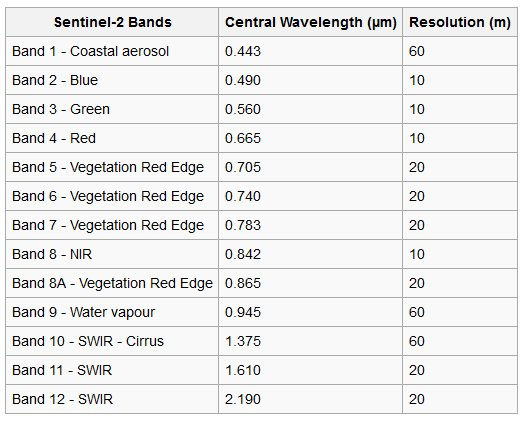

## 3.1. Select and download of Sentinel-2 data (i.sentinel)

In [ ]:
#!pip install sentinelsat

In [ ]:
#gs.run_command("g.extension", extension="i.sentinel")

[Manual i.sentinel.download](https://grass.osgeo.org/grass83/manuals/addons/i.sentinel.download.html)

In [ ]:
# list available Sentinel-2 L2A scenes for AOI
# note that we use parse_command() in order to intercept the output for display in the browser
"""gs.parse_command("i.sentinel.download", 
                 flags="l",
                 map="tile_cba_1km", 
                 producttype="S2MSI2A",
                 settings=homedir+"/gisdata/esa_credentials.txt",
                 start="2020-03-01", 
                 end="2020-04-30", 
                 clouds="30",
                 sort="cloudcoverpercentage",
                 footprints="s2_footprints",
                 area_relation="Contains")"""


In [ ]:
# download selected scene
"""s2_data = os.path.join(homedir, "gisdata", "s2_data")

gs.run_command("i.sentinel.download", 
               settings=homedir+"/gisdata/esa_credentials.txt", 
               uuid="S2A_MSIL1C_20240324T140711_N0510_R110_T20JLL_20240324T190903.SAFE",
               output=s2_data)"""

[Manual i.sentinel.import](https://grass.osgeo.org/grass83/manuals/addons/i.sentinel.import.html)

In [ ]:
# print bands info before importing
# (1 -proj match, 0 -no proj match)
"""gs.run_command("i.sentinel.import", 
               input="/home/tomas/gisdata", 
               flags="p")"""

## 3.2. Import Sentinel-2 data (without i.sentinel)

<div> 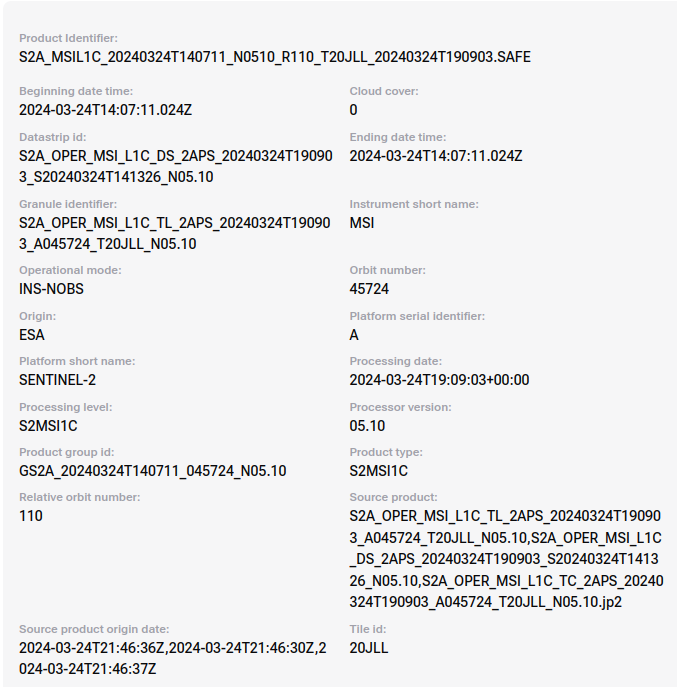</div>

In [ ]:
#directory
sentinel_data = "/home/tomas/gisdata/GIS_MCDA/s2_data/S2A_MSIL1C_20240324T140711_N0510_R110_T20JLL_20240324T190903/"

#02:B;03:G,04:R;08:NIR
#Import each band
gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B02.jp2"),
               output="s2a_B02",
               resolution="value",
               resolution_value=10,
               extent="region")

gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B03.jp2"),
               output="s2a_B03",
               resolution="value",
               resolution_value=10,
               extent="region")

gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B04.jp2"),
               output="s2a_B04",
               resolution="value",
               resolution_value=10,
               extent="region")

gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B08.jp2"),
               output="s2a_B08",
               resolution="value",
               resolution_value=10,
               extent="region")

In [ ]:
cba_blue = gj.Map(width=300, use_region=True)
cba_blue.d_rast(map="s2a_B02")
cba_blue.show()

In [ ]:
# Enhance the colors
gs.run_command("i.colors.enhance",
               red="s2a_B04",
               green="s2a_B03",
               blue="s2a_B02",
               strength="95")

In [ ]:
# Display RGB natural color using gj.Map
rgb_map = gj.Map(width=500, use_region=True)
rgb_map.d_rgb(red="s2a_B04",
              green="s2a_B03",
              blue="s2a_B02",)
rgb_map.show()

In [ ]:
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="p",
               vector="tile_cba_1km",
               align="s2a_B04",
               res=10
               )

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("s2a_B04")
cba_map.add_raster("s2a_B03")
cba_map.add_raster("s2a_B02")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

# 4. Spectral indices

#### <p style="color:red;"> To do:</p> 
<p style="color:red;">- Buscar info sobre metodologias para representar de mejor manera la vegetación urbana con sentinel-2.</p>
<p style="color:red;">- Ver mas sobre SAVI y en https://github.com/awesome-spectral-indices/spectral . </p>

## 4.1. NDVI

In [ ]:
# Estimate vegetation index. 02:B;03:G,04:R;08:NIR
gs.run_command("i.vi", 
               red="s2a_B04", 
               nir="s2a_B08", 
               output="s2a_NDVI", 
               viname="ndvi")

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("s2a_NDVI", opacity=0.8)
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="s2a_NDVI")
cba_ndvi.d_legend(raster="s2a_NDVI",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="-1,1",
                  flags="db")
cba_ndvi.show()

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="s2a_NDVI"))

## 4.2. NDWI

In [ ]:
### NO ANDA i.wi

"""gs.run_command("g.extension",
               extension="i.wi")

# Estimate water index. 02:B;03:G,04:R;08:NIR
gs.run_command("i.wi", 
               green="s2a_B03", 
               nir="s2a_B08", 
               output="s2a_NDWI", 
               winame="ndwi_mf")"""

In [ ]:
# Estimate water index. 02:B;03:G,04:R;08:NIR
gs.run_command("i.vi", 
               green="s2a_B03", 
               nir="s2a_B08", 
               output="s2a_NDWI", 
               viname="ndwi")

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="s2a_NDWI"))

In [ ]:
# set ndwi color palette
gs.run_command("r.colors", 
               map="s2a_NDWI", 
               color="ndwi")

In [ ]:
cba_ndwi = gj.Map(width=500, use_region=True)
cba_ndwi.d_rast(map="s2a_NDWI")
cba_ndwi.d_legend(raster="s2a_NDWI",
                  #title="NDWI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="-1,1",
                  flags="db")

cba_ndwi.show()

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("s2a_NDVI")
cba_map.add_raster("s2a_NDWI")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

## 4.2. SAVI (Soil Adjusted Vegetation Index)

In [ ]:
# Estimate Soil Adjusted Vegetation Index. 02:B;03:G,04:R;08:NIR
gs.run_command("i.vi", 
               red="s2a_B04", 
               nir="s2a_B08", 
               output="s2a_SAVI", 
               viname="savi")

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="s2a_SAVI"))

In [ ]:
cba_savi = gj.Map(width=500, use_region=True)
cba_savi.d_rast(map="s2a_SAVI")
cba_savi.d_legend(raster="s2a_SAVI",
                  #title="NDWI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="-1,1",
                  flags="db")

cba_savi.show()

# 5. Buildings

Data:
- DEM: Modelo Digital de Elevaciones (5m). [IDECOR](https://www.mapascordoba.gob.ar/#/descargas) 

    Descargas ${\to}$ Geografia fisica ${\to}$  DEM 5m
- [FABDEM](https://gee-community-catalog.org/projects/fabdem/): Forest And Buildings removed Copernicus 30m DEM . 

    Tile corresponding to Córdoba: S40W070-S30W060_FABDEM_V1-2.zip ; S32W065_FABDEM_V1-2.tif
- [Open buildings](https://sites.research.google/open-buildings/): A deep learning model was trained to determine the footprints of buildings from high resolution satellite imagery. 

    Tile corresponding to Córdoba: 943_buildings.csv.gz . En QGIS lo pasé a gpkg y reproyecté a 5346.
        
Future: 

- Automated DEM download:
        
    [r.in.nasadem](https://grass.osgeo.org/grass83/manuals/addons/r.in.nasadem.html) : Creates a DEM from 1 arcsec NASADEM tiles.
        
    [r.in.srtm.region](https://grass.osgeo.org/grass83/manuals/addons/r.in.srtm.region.html) - Creates a DEM from 3 arcsec SRTM v2.1 or 1 arcsec SRTM v3 tiles.

#### <p style="color:red;"> To do:</p> 
<p style="color:red;">- Subir resolucion a FABDEM a 5m para que coincida con DEM.</p>
    
<p style="color:red;">- Hacer resta DEM y FABDEM, extraer valor para cada poligono de open buildings para tener la altura de cada construcción.</p>

<p style="color:red;">- Chequear que open buildings este bien.</p>

<div> 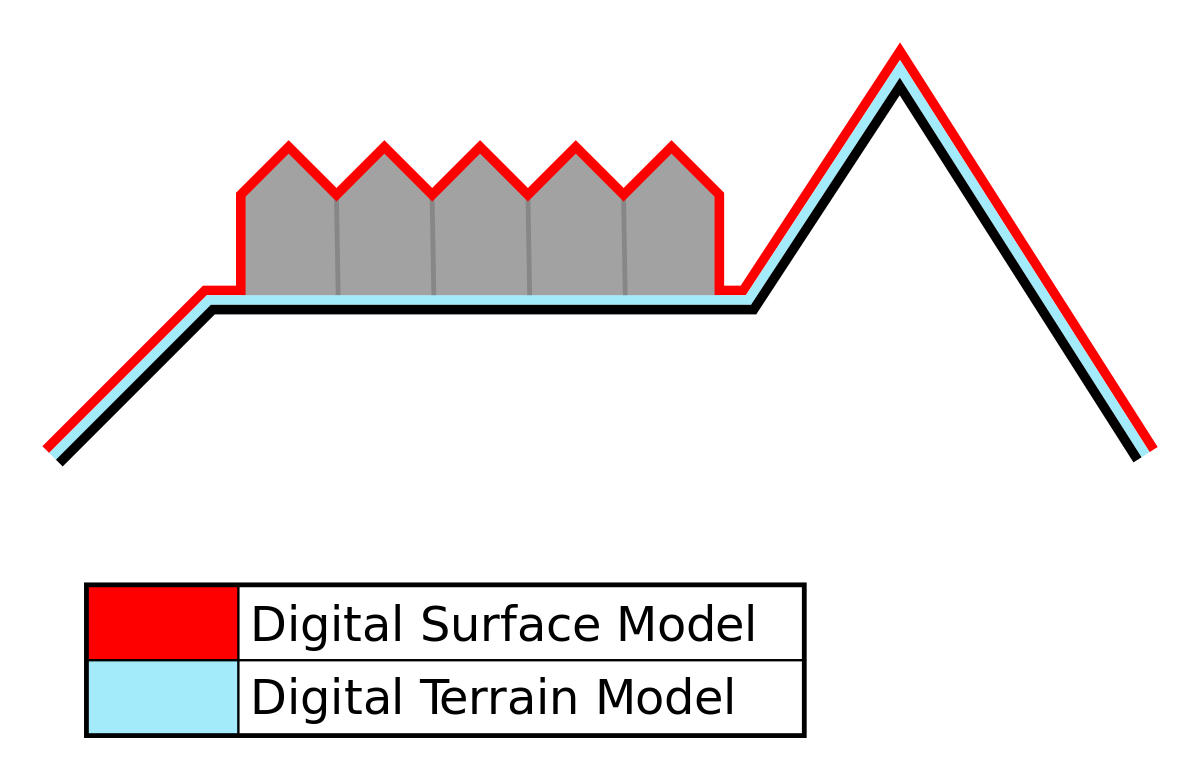</div> 

DEM (DSM. relieve+arboles+edificos) - FADBEM (DTM. solo el terreno, sin arboles y edificios) = Altura de edificaciones  --> a partir de los poligonos de open buildings sacar info sobre cada construcción --> categorizamos y agrupamos de alguna forma

## 5.1. DEM

In [ ]:
#importar DEM
gs.run_command("r.import",
               input=os.path.join(homedir+"/gisdata/GIS_MCDA/dem_5m_cba_ext.tif"),
               output="DEM_5m",
               resolution="value",
               resolution_value=5,
               extent="region")

In [ ]:
# Visualize results in an interactive map
dem_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
dem_map.add_raster("DEM_5m")
dem_map.add_layer_control(position = "bottomright")
dem_map.show()

## 5.2. FABDEM

In [ ]:
#importar FABDEM
gs.run_command("r.import",
               input=os.path.join(homedir+"/gisdata/GIS_MCDA/S32W065_FABDEM_V1-2.tif"),
               output="FABDEM_30m",
               resolution="value",
               resolution_value=30,
               extent="region")

In [ ]:
# Visualize results in an interactive map
fabdem_map=gj.InteractiveMap(width = 400, tiles="CartoDB positron", use_region=True)
fabdem_map.add_raster("FABDEM_30m")
fabdem_map.add_layer_control(position = "bottomright")
fabdem_map.show()

## 5.3. Open Buildings

En qgis: pasé de csv a gpkg, reproyecté a 5346 y recorté al area de cordoba

In [ ]:
# Import
gs.run_command("v.import", input=homedir+"/gisdata/GIS_MCDA/open_buildings_cba_5346.gpkg", extent="region", output="open_buildings", epsg="5346")

In [ ]:
# to extract values of AOI (I did this in QGIS)
#v.clip

In [ ]:
# show metadata
gs.vector_info("open_buildings")

In [ ]:
!v.info map=open_buildings

In [ ]:
ob = gj.Map(width=500, use_region=True)
ob.d_vect(map="open_buildings", type="boundary", color="yellow")
ob.show()

In [ ]:
## NO ANDA

# display open_buildings vector
"""ob_map = gj.InteractiveMap(width = 1000, use_region=True, tiles="OpenStreetMap")
ob_map.add_vector("open_buildings")
ob_map.add_layer_control(position = "bottomright")
#ob_map.save("prueba.html")
ob_map.show()"""

## 5.4. Calculations

# 6. Human population density

#### <p style="color:red;"> To do:</p> 
<p style="color:red;">- Base de datos de densidad poblacional: Worldpop, GHSL. ¿Ver y comparar las dos?. Poblaciones.org </p>

# 7. Socioeconomic

#### <p style="color:red;"> To do:</p> 
<p style="color:red;">- Buscar fuentes de información. </p>

# 8. MCDA

## 8.1. Generate random matrices and test the MCDA module.

- en un csv lee bien la matriz.
- los datos no tienen que valer 0 (o negativos). --> a chequear
- los input no pueden ser numpys.
- En GUI funcionó con las matrices aleatorias y cargando el csv: genera la capa y un txt con cosas.

### Generate random matrices

In [ ]:
!r.surf.random out=matrix1 min=0.0001 max=1

In [ ]:
!r.univar matrix1

In [ ]:
cba_matrix1 = gj.Map(width=300, use_region=True)
cba_matrix1.d_rast(map="matrix1")
cba_matrix1.show()

In [ ]:
!r.surf.random out=matrix2 min=0.0001 max=1
!r.surf.random out=matrix3 min=0.0001 max=1

In [ ]:
#Download matrices as raster file
gs.run_command("r.out.gdal",
               input="matrix1",
               output="matrix1.tif")

gs.run_command("r.out.gdal",
               input="matrix2",
               output="matrix2.tif")

gs.run_command("r.out.gdal",
               input="matrix3",
               output="matrix3.tif")

### Test the MCDA module

In [ ]:
#!r.mcda.ahp criteria="matrix1","matrix2","matrix3" pairwise="/home/tomas/gisdata/GIS_MCDA/AHP/pairwise.csv" output=mcda_ahp

- matrices aleatorias:
<div> 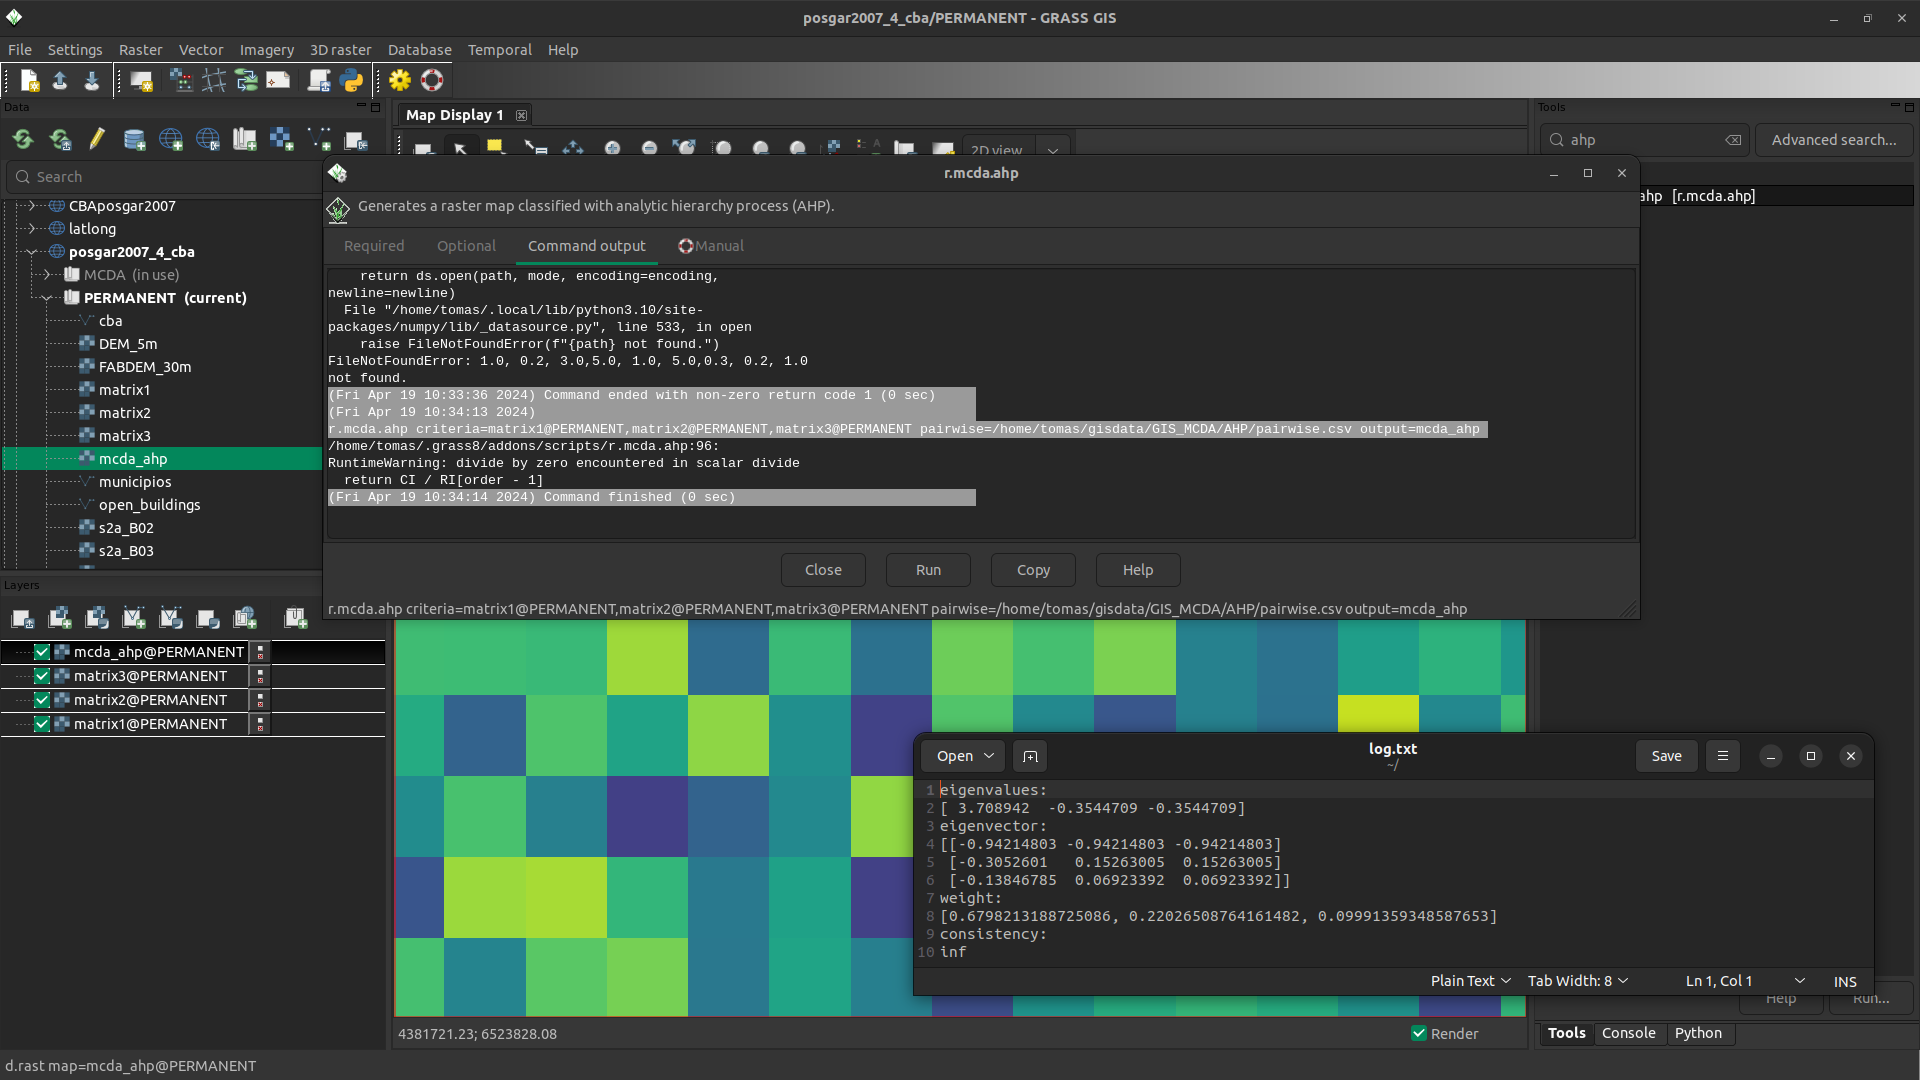</div>

- indices: 
<div> 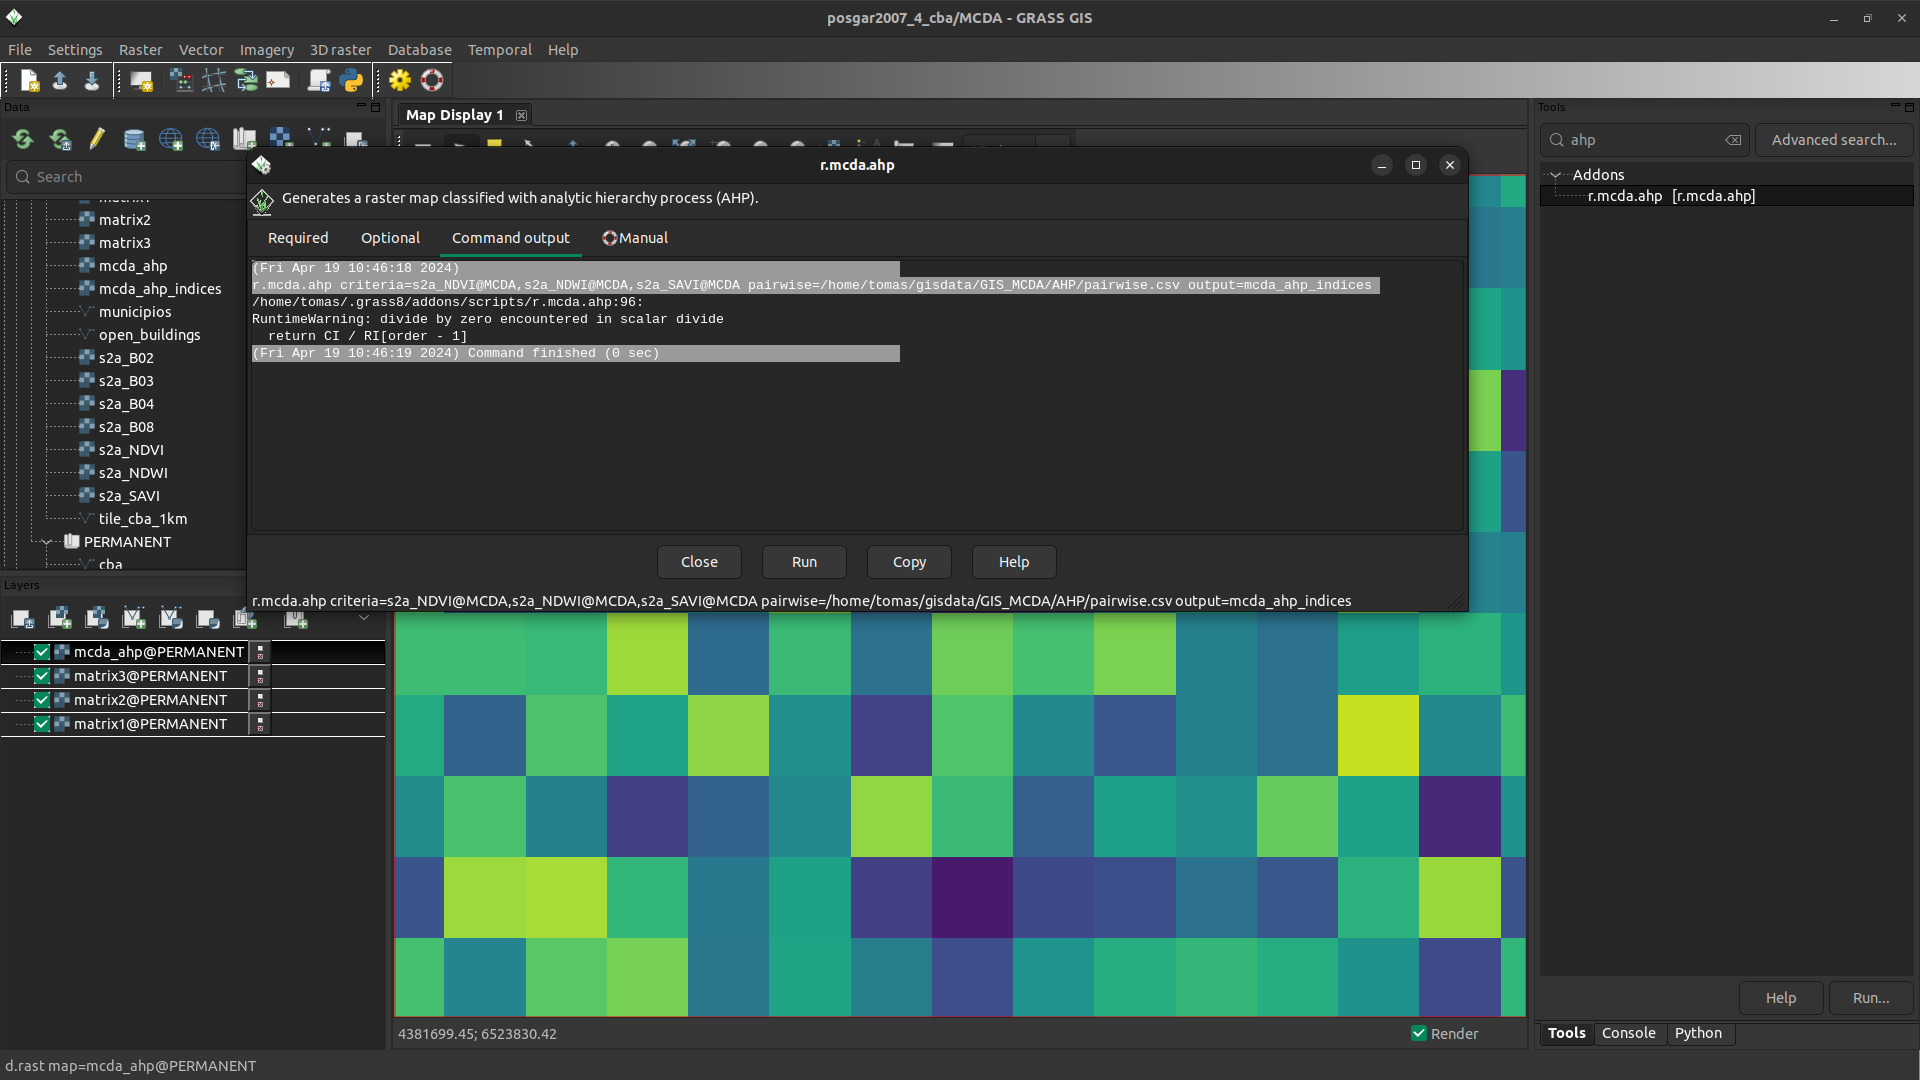</div>